## TO-DO
- Evaluation (metrics) -> plot of training vs epoch for all, AUC
- Ablation study: CV comparing binary vs no binary for MTL

Training/implementation methodologies: Need to be more scientific in how we chose
- Hyper parameters e.g LR (LR finder), batch_size (quote frozen batch norm)
- CV for ablation, fine-tuning, 

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import numpy as np
import random
import matplotlib.pyplot as plt

from utils.loader import DataLoader
from models.effnet_encoder import EffnetEncoder
from models.mtl_framework import MTLFramework
from utils import tools, config

In [2]:
# Set configs
batch_size = 7
batch_size_val = 7
num_train, num_val, num_test = config.config['num_train'], config.config['num_val'], config.config['num_test']
img_height, img_width, channels = config.config['input_shape']

In [5]:
# Load our data pipeline
loader = DataLoader(batch_size=batch_size, batch_size_val=batch_size_val)

# Train set
img_ds = loader.get_image_ds().repeat()
masks_ds = loader.get_mask_ds().repeat()
label_ds = loader.get_binary_ds().repeat()
bbox_ds = loader.get_bboxes_ds().repeat()

# Validation set
img_ds_val = loader.get_image_ds(val=True).repeat()
masks_ds_val = loader.get_mask_ds(val=True).repeat()
label_ds_val = loader.get_binary_ds(val=True).repeat()
bbox_ds_val = loader.get_bboxes_ds(val=True).repeat()

Plot some examples (Ignore if training)

In [4]:
# Make some examples
examples = tf.data.Dataset.zip((img_ds, masks_ds, bbox_ds)).as_numpy_iterator()
display_list = next(examples)

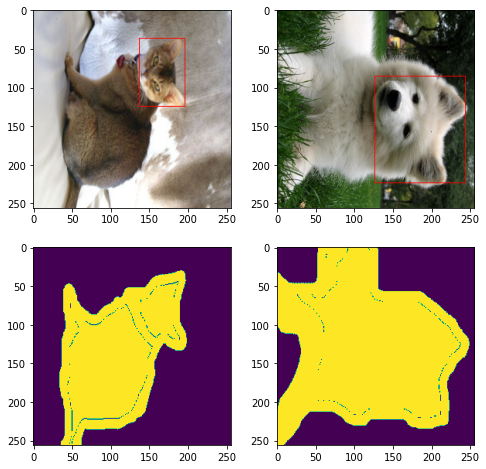

In [7]:
# View some examples with augmentation
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(8,8))
display_list = tools.data_augmentation(display_list[0], display_list[1], display_list[2])
for i in range(2):
    box_img = tf.image.draw_bounding_boxes(tf.expand_dims(display_list[0][i,...], 0), tools.fix_bbox(display_list[2][i]).reshape([1,1,4])/256, np.array([[255, 0, 0]]))
    ax1[i].imshow(tf.keras.utils.array_to_img(tf.squeeze(box_img)))
    ax2[i].imshow((display_list[1][i,...]))

Build our MTL

In [ ]:
### CLEARS OLD MODELS IN CACHE
tf.keras.backend.clear_session()

In [3]:
# Get encoder
base_model_name = 'B0'
encoder = EffnetEncoder(base_model_name, (img_height, img_width, channels)).build_encoder(trainable=True)

In [ ]:
encoder.summary()

In [5]:
# Use our MTL framework to custom build a model
mtl_builder = MTLFramework(encoder, (img_height, img_width, channels))
mtl_builder.add_segmentation_head()
mtl_builder.add_binary_classification_head(base_model_name, trainable=True)
mtl_builder.add_bbox_classification_head(base_model_name, trainable=True)
model = mtl_builder.build_mtl_model()

In [ ]:
model.summary()

Train model

In [4]:
def generator_img():
    ''' Merges together datasets into a unified generator to pass for training '''
    a = img_ds.as_numpy_iterator()
    b = masks_ds.as_numpy_iterator()
    c = label_ds.as_numpy_iterator()
    d = bbox_ds.as_numpy_iterator()
    
    while True:
        X = a.next()
        Y1 = b.next()
        Y2 = c.next()
        Y3 = d.next()
        
        # Regularisation and shuffling
        X, Y1, Y2, Y3 = tools.get_randomised_data([X, Y1, Y2, Y3])
        X, Y1, Y3 = tools.data_augmentation(X, Y1, Y3) # Fix augmentation
        
        yield X, (Y1, Y2, Y3)

In [6]:
def generator_img_val():
    ''' Merges together datasets into a unified generator to pass for training '''
    a = img_ds_val.as_numpy_iterator()
    b = masks_ds_val.as_numpy_iterator()
    c = label_ds_val.as_numpy_iterator()
    d = bbox_ds.as_numpy_iterator()
    
    while True:
        X = a.next()
        Y1 = b.next()
        Y2 = c.next()
        Y3 = d.next()
        
        yield X, (Y1, Y2, Y3)

In [7]:
model.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss={'segnet_out' : tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    'bin_class_out' : tf.keras.losses.BinaryCrossentropy(),
                    'bbox_out' : tf.keras.losses.MeanAbsoluteError()},
              loss_weights=[1,1,1/100], # Scale MAE to BC range
              metrics=['accuracy'])

In [8]:
history = model.fit(generator_img(), validation_data=generator_img_val(), epochs=10, steps_per_epoch=num_train//batch_size, validation_steps=num_val//batch_size_val)

Epoch 1/10
315/315 [==============================] - 135s 391ms/step - loss: 0.3523 - segnet_out_loss: 0.1309 - bin_class_out_loss: 0.0180 - bbox_out_loss: 20.3344 - segnet_out_accuracy: 0.9480 - bin_class_out_accuracy: 0.9946 - bbox_out_accuracy: 0.7605 - val_loss: 0.5638 - val_segnet_out_loss: 0.1297 - val_bin_class_out_loss: 0.0204 - val_bbox_out_loss: 41.3710 - val_segnet_out_accuracy: 0.9477 - val_bin_class_out_accuracy: 0.9918 - val_bbox_out_accuracy: 0.5578
Epoch 2/10
315/315 [==============================] - 118s 376ms/step - loss: 0.3216 - segnet_out_loss: 0.1231 - bin_class_out_loss: 0.0038 - bbox_out_loss: 19.4713 - segnet_out_accuracy: 0.9511 - bin_class_out_accuracy: 0.9995 - bbox_out_accuracy: 0.7628 - val_loss: 0.5566 - val_segnet_out_loss: 0.1276 - val_bin_class_out_loss: 0.0221 - val_bbox_out_loss: 40.6834 - val_segnet_out_accuracy: 0.9493 - val_bin_class_out_accuracy: 0.9918 - val_bbox_out_accuracy: 0.6014
Epoch 3/10
315/315 [==============================] - 120s 3

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(list(range(10)), history.history['segnet_out_accuracy'], 'r-', label='Segmentation - Training Accuracy')
ax.plot(list(range(10)), history.history['val_segnet_out_accuracy'], 'r--', label='Segmentation - Validation Accuracy')
ax.plot(list(range(10)), history.history['bin_class_out_accuracy'], 'c-', label='Classification - Training Accuracy')
ax.plot(list(range(10)), history.history['val_bin_class_out_accuracy'], 'c--', label='Classification - Validation Accuracy')
ax2 = ax.twinx()
ax.plot(list(range(10)), history.history['bbox_out_accuracy'], 'm-', label='Bounding Box - Training Accuracy')
ax.plot(list(range(10)), history.history['val_bbox_out_accuracy'], 'm--', label='Bounding Box - Validation Accuracy')
ax.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('Segmentation/Classification Accuracy')
ax2.set_ylabel('Bounding Box Accuracy')

In [5]:
model.save_model('model_weights/EffishingNetAtt')

## Test on test-set

In [3]:
model = tf.keras.models.load_model('model_weights/EffishingNetN')

In [6]:
# Load test-set
img_ds_test = loader.get_image_ds(test_mode=True)
masks_ds_test = loader.get_mask_ds(test_mode=True)
label_ds_test = loader.get_binary_ds(test_mode=True)
bbox_ds_test = loader.get_bboxes_ds(test_mode=True)

In [8]:
# Predict on test-set
seg_pred, bin_pred, bbox_pred = model.predict(img_ds_test, batch_size=10)
seg_pred = tf.where(seg_pred >= 0, 1, 0) # Convert to {0,1} binary classes
bin_pred = np.round(bin_pred) # Round confidence score

bin_acc = np.sum(bin_pred == label_ds_test)/label_ds_test.shape[0]
seg_acc = np.sum(seg_pred == masks_ds_test)/(masks_ds_test.shape[0]*(img_height*img_width))
iou = np.mean(tools.calculate_iou(bbox_ds_test, bbox_pred))
print(f'Binary Acc: {round(bin_acc*100, 3)}%,   Seg Acc: {round(seg_acc*100, 3)}%,    BBox IOU: {round(iou*100, 3)}%')

Binary Acc: 99.593%,   Seg Acc: 95.391%,    BBox IOU: 72.283%


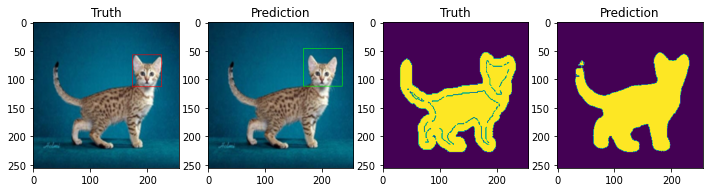

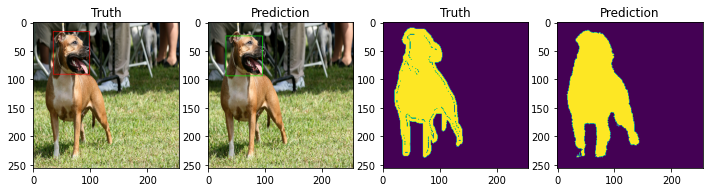

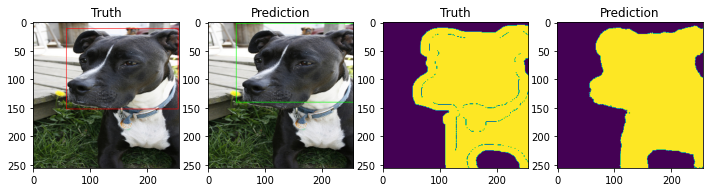

In [15]:
# Visualise predictions
idx = list(range(img_ds_test.shape[0]))
random.shuffle(idx)
for i in range(3):
    tools.show_seg_pred(img_ds_test[idx[i]], masks_ds_test[idx[i]], seg_pred[idx[i]][tf.newaxis, ...], bbox_ds_test[idx[i]], bbox_pred[idx[i]])